In [2]:
import cv2
import matplotlib.pyplot as plt
import glob
import os
import shutil
import numpy as np
import torch.nn as nn
import torch
import torchvision.transforms as transforms


from torch import Generator
from torch.utils.data import Dataset, DataLoader, Subset, random_split, SubsetRandomSampler
from sklearn.model_selection import train_test_split

In [3]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device) 


cuda


In [4]:
base_path = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Pandora_18k_Merged\\"

folders = [ f.path for f in os.scandir(base_path) if f.is_dir() ]
classes_names = [ f.name for f in os.scandir(base_path) if f.is_dir() ]
classes = ["1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18"]

class_mapping = {
    "01_Byzantin_Iconography": 0,
    "02_Early_Renaissance":1,
    "03_Northern_Renaissance":2,
    "04_High_Renaissance":3,
    "05_Baroque":4,
    "06_Rococo":5,
    "07_Romanticism":6,
    "08_Realism":7,
    "09_Impressionism":8,
    "10_Post_Impressionism":9,
    "11_Expressionism":10,
    "12_Symbolism":11,
    "13_Fauvism":12,
    "14_Cubism":13,
    "15_Surrealism":14,
    "16_AbstractArt":15,
    "17_NaiveArt":16,
    "18_PopArt" : 17
}

image_path_by_class = []
aux_str = []

for folder in folders:
    aux_str = folder + "//" + "*.jpg"
    image_path_by_class.append(glob.glob(aux_str))
print(classes_names)

['01_Byzantin_Iconography', '02_Early_Renaissance', '03_Northern_Renaissance', '04_High_Renaissance', '05_Baroque', '06_Rococo', '07_Romanticism', '08_Realism', '09_Impressionism', '10_Post_Impressionism', '11_Expressionism', '12_Symbolism', '13_Fauvism', '14_Cubism', '15_Surrealism', '16_AbstractArt', '17_NaiveArt', '18_PopArt']


In [5]:
labels = []
for index, class_path in enumerate(image_path_by_class):
  tmp = []
  for img_path in class_path:
    label = img_path.split("\\")[6]
    tmp.append(label)
  labels.append(tmp)

# labels=np.array(labels)
# print(labels)
print(len(labels[2]))
print(len(image_path_by_class[2]))

# len(labels)
targets = []
for label in labels:
    tmp = []
    for img_label in label:
      tmp.append(img_label)
    targets.append(tmp)


print(len(targets[2]))


802
802
802


11_Expressionism


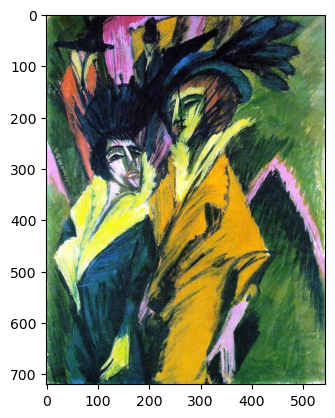

In [6]:
class_name = 10
picture = 100

test_img = cv2.imread(image_path_by_class[class_name][picture])
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(test_img)

print(labels[class_name][picture])

## Split into Train and Test

The result will be
1. a list: `train_data` that will contain the paths to the images
2. a list: `train_data_labels` the will contain the labels of the images

the split will be 80% train and 20% test, but the proportions can be changed in `train_test_split` method

In [7]:
data = image_path_by_class
data = []
labels_merged = []
for class_index in range(len(image_path_by_class)):
    for img_index in range(len(image_path_by_class[class_index])):
        data.append(image_path_by_class[class_index][img_index])

for class_index in range(len(labels)):
    for img_index in range(len(labels[class_index])):
        labels_merged.append(labels[class_index][img_index])

print(len(data))

# train_data0, test_data0 = random_split(data, [0.7, 0.3], generator=Generator().manual_seed(42))

train_data, test_data, train_labels, test_labels = train_test_split(
    data,
    labels_merged,
    test_size=0.2,
    random_state=42
)
print("Test and Train:")
print(len(train_data))
print(len(test_data))
print("Test and Train Labels:")
print(len(train_labels))
print(len(test_labels))



17591
Test and Train:
14072
3519
Test and Train Labels:
14072
3519


12_Symbolism


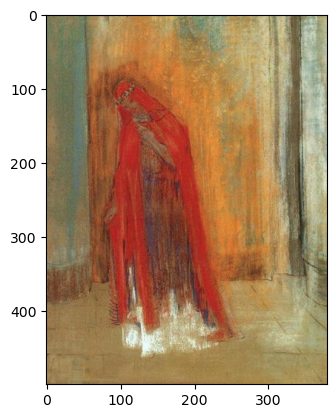

In [8]:
picture = 1300

test_img = cv2.imread(train_data[picture])
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(test_img)

print(train_labels[picture])

## Define the Dataset

In [9]:
class DatasetPandora(Dataset):
    def __init__(self, image_paths, labels):
        
        self.data = image_paths
        self.labels = labels
        self.targets = []
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


        for label in labels:
            self.targets.append(class_mapping[label])

        self.transf = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):

        img = cv2.imread(self.data[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # img = np.transpose(img, [2,0,1])

        batch_data = img
        batch_data = self.transf(batch_data)
        # batch_data = batch_data.to(self.device)

        batch_targets = self.targets[idx]
        # batch_targets = batch_targets.to(self.device)

        batch_labels = self.labels[idx]
        # batch_labels = batch_labels.to(self.device)

        batch = {'data': batch_data, 'labels': batch_labels, 'targets': batch_targets}

        return batch_data, batch_labels, batch_targets

train_data_dataset = DatasetPandora(train_data, train_labels)
train_loader = DataLoader(train_data_dataset, batch_size=128, shuffle=True, num_workers=0)

# test_data_dataset = DatasetPandora(test_data, train_labels)
# test_loader = DataLoader(test_data_dataset, batch_size=128)


# for batch in train_loader:
#     # plt.figure()
#     # plt.imshow(batch["data"][0])
#     print(batch["data"][0])
#     print(batch["label"][0])
#     break


# Define the network

In [67]:
class Retea_CNN(nn.Module):
    
    def __init__(self, nr_clase):
        
        # Pentru a putea folosi mai departe reteaua, este recomandata mostenirea
        # clasei de baza nn.Module
        super(Retea_CNN,self).__init__()
        
        # 3, 224, 224
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=[3, 3], stride = [1, 1], padding = [1, 1])
        self.relu1 = nn.ReLU()
        # 6, 224, 224
        self.maxpool1 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2])

        # 6, 112, 112
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=9, kernel_size=[3, 3], stride = [1, 1], padding = [1, 1])
        self.relu2 = nn.ReLU()
        # 9, 112, 112
        self.maxpool2 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2])

        # 9, 56, 56
        self.fc1 = nn.Linear(in_features=56*56*9, out_features=256)
        self.relu3 = nn.ReLU()
        self.out = nn.Linear(in_features=256, out_features=nr_clase)
    
    def forward(self,input_batch):

        x = self.conv1(input_batch)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = torch.flatten(x, 1, 3)
        x = self.fc1(x)
        x = self.relu3(x)
        out = self.out(x)
        
        return out
    

In [ ]:
# Instantiem reteaua
cnn = Retea_CNN(18)

# Specificarea functiei loss
loss_function = nn.CrossEntropyLoss(reduction='sum')

# Specificarea optimizatorului
optim = torch.optim.Adam(cnn.parameters(), lr=1e-5)

# Definim dataset
train_data_dataset = DatasetPandora(train_data, train_labels)
train_loader = DataLoader(train_data_dataset, batch_size=128, shuffle=True, num_workers=0)

nr_epoci = 15

for ep in range(nr_epoci):
    predictii = []
    etichete = []

    for batch in train_loader:
        batch_data = batch['data']
        batch_labels = batch['labels']
        batch_targets = batch['targets']
        # Se calculeaza predictia retelei pentru datele curente (forward pass/ propagare inainte)
        current_predict = cnn.forward(batch_data)

        # Se calculeaza valoarea momentana a functiei loss
        loss = loss_function(current_predict, batch_targets) 
        
        # Se memoreaza predictiile si etichetele aferente batch-ului actual (pentru calculul acuratetii)
        current_predict = np.argmax(current_predict.detach().numpy(), axis=1)
        predictii = np.concatenate((predictii,current_predict))
        etichete = np.concatenate((etichete,batch_labels))
        
        # Antrenarea propriu-zisa
        
            # 1. Se sterg toti gradientii calculati anteriori, pentru toate variabilele antrenabile
            # deoarece, metoda <backward> acumuleaza noile valori, in loc sa le inlocuiasca.
        optim.zero_grad()
            # 2. Calculul tuturor gradientilor. Backpropagation
        loss.backward()
            # 3. Actualizarea tuturor ponderilor, pe baza gradientilor.
        optim.step()
    
    # Calculam acuratetea
    acc = np.sum(predictii==etichete)/len(predictii)
    print( 'Acuratetea la epoca {} este {}%'.format(ep+1,acc*100) )

# MobileNet

In [10]:
mobile_net = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
# print(mobile_net)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobile_net.to(device)
print("The model will be running on", device)


Using cache found in C:\Users\Teodora/.cache\torch\hub\pytorch_vision_v0.10.0
e:\Programe\Anaconda\envs\Pytorch\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
e:\Programe\Anaconda\envs\Pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The model will be running on cuda


In [ ]:
for param in mobile_net.parameters():
    param.requires_grad = False

mobile_net.classifier[1] = nn.Linear(in_features=1280, out_features=18, bias=True)

# LOAD NET
mobile_net.load_state_dict(torch.load('mobileNet_PandoraTrain1.pt'))

# mobile_net.classifier[6] = nn.Linear(in_features=4096, out_features=18, bias=True)

# Specificarea functiei loss
loss_function = nn.CrossEntropyLoss(reduction='sum')

# Specificarea optimizatorului
optim = torch.optim.Adam(mobile_net.parameters(), lr=1e-3)

# Definim dataset
train_data_dataset = DatasetPandora(train_data, train_labels)
train_loader = DataLoader(train_data_dataset, batch_size=128, shuffle=True, num_workers=0)
# accuracy = []
nr_epoci = 100
mobile_net.train()
mobile_net.cuda()
for ep in range(nr_epoci):
    predictii = []
    etichete = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # print("The model will be running on", device)

    for batch in train_loader:
        batch_data, batch_labels, batch_targets = batch
        etichete = np.concatenate((etichete,batch_targets))


        batch_data = batch_data.to(torch.device('cuda'))
        # batch_labels = batch_labels.to(torch.device('cuda'))
        batch_targets = batch_targets.to(torch.device('cuda'))


        # batch_data = batch['data'].to(torch.device('cuda'))
        # batch_labels = batch['labels'].to(torch.device('cuda'))
        # batch_targets = batch['targets'].to(torch.device('cuda'))
        
        # Se calculeaza predictia retelei pentru datele curente (forward pass/ propagare inainte)
        current_predict = mobile_net.forward(batch_data)

        # Se calculeaza valoarea momentana a functiei loss
        loss = loss_function(current_predict, batch_targets) 
        
        # Se memoreaza predictiile si etichetele aferente batch-ului actual (pentru calculul acuratetii)
        current_predict = current_predict.to(torch.device('cpu'))
        # batch_targets = batch_targets.to(torch.device('cpu'))
        current_predict = np.argmax(current_predict.detach().numpy(), axis=1)
        predictii = np.concatenate((predictii,current_predict))

        # print(predictii)
        # print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        # print(etichete)

        
        # Antrenarea propriu-zisa
        
            # 1. Se sterg toti gradientii calculati anteriori, pentru toate variabilele antrenabile
            # deoarece, metoda <backward> acumuleaza noile valori, in loc sa le inlocuiasca.
        optim.zero_grad()
            # 2. Calculul tuturor gradientilor. Backpropagation
        loss.backward()
            # 3. Actualizarea tuturor ponderilor, pe baza gradientilor.
        optim.step()
    
    # Calculam acuratetea
    acc = np.sum(predictii==etichete)/len(predictii)
    # accuracy.append(acc)
    print( 'Acuratetea la epoca {} este {}%'.format(ep+1,acc*100) )
    # print("Epoca: ", ep)


    # torch.save(mobile_net.state_dict(), '/content/drive/MyDrive/mobileNet_PandoraTrain.pt')

In [13]:
torch.save(mobile_net.state_dict(), './mobileNet_PandoraTrain1.pt')

# Testare

In [11]:
test_data_dataset = DatasetPandora(test_data, test_labels)
test_loader = DataLoader(train_data_dataset, batch_size=128, shuffle=True, num_workers=0)

In [12]:
for param in mobile_net.parameters():
    param.requires_grad = False

mobile_net.classifier[1] = nn.Linear(in_features=1280, out_features=18, bias=True)

# LOAD NET
mobile_net.load_state_dict(torch.load('mobileNet_PandoraTrain1.pt'))
mobile_net.eval()
mobile_net.cuda()

predictii = []
real_labels = []
mobile_net.eval()

for batch in test_loader:
    batch_data, batch_labels, batch_targets = batch
    real_labels = np.concatenate([real_labels, batch_targets])


    batch_data = batch_data.to(torch.device('cuda'))
    batch_targets = batch_targets.to(torch.device('cuda'))
    batch_data.size()
    # batch_data = batch['date']
    # batch_labels = batch['etichete']


    current_predict = mobile_net.forward(batch_data)
    current_predict = current_predict.to(torch.device('cpu'))
    current_predict = np.argmax(current_predict.detach().numpy(),axis=1)
    predictii = np.concatenate((predictii,current_predict))


acc = np.sum(predictii==real_labels)/len(predictii)

precision = np.sum(predictii==real_labels) / ( np.sum(predictii!=real_labels) + np.sum(predictii==real_labels))
print( 'Acuratetea la test este {}%'.format(acc*100) )
print( 'Precizia la test este {}%'.format(precision*100) )

In [14]:
print(batch_data.size())

torch.Size([120, 3, 224, 224])


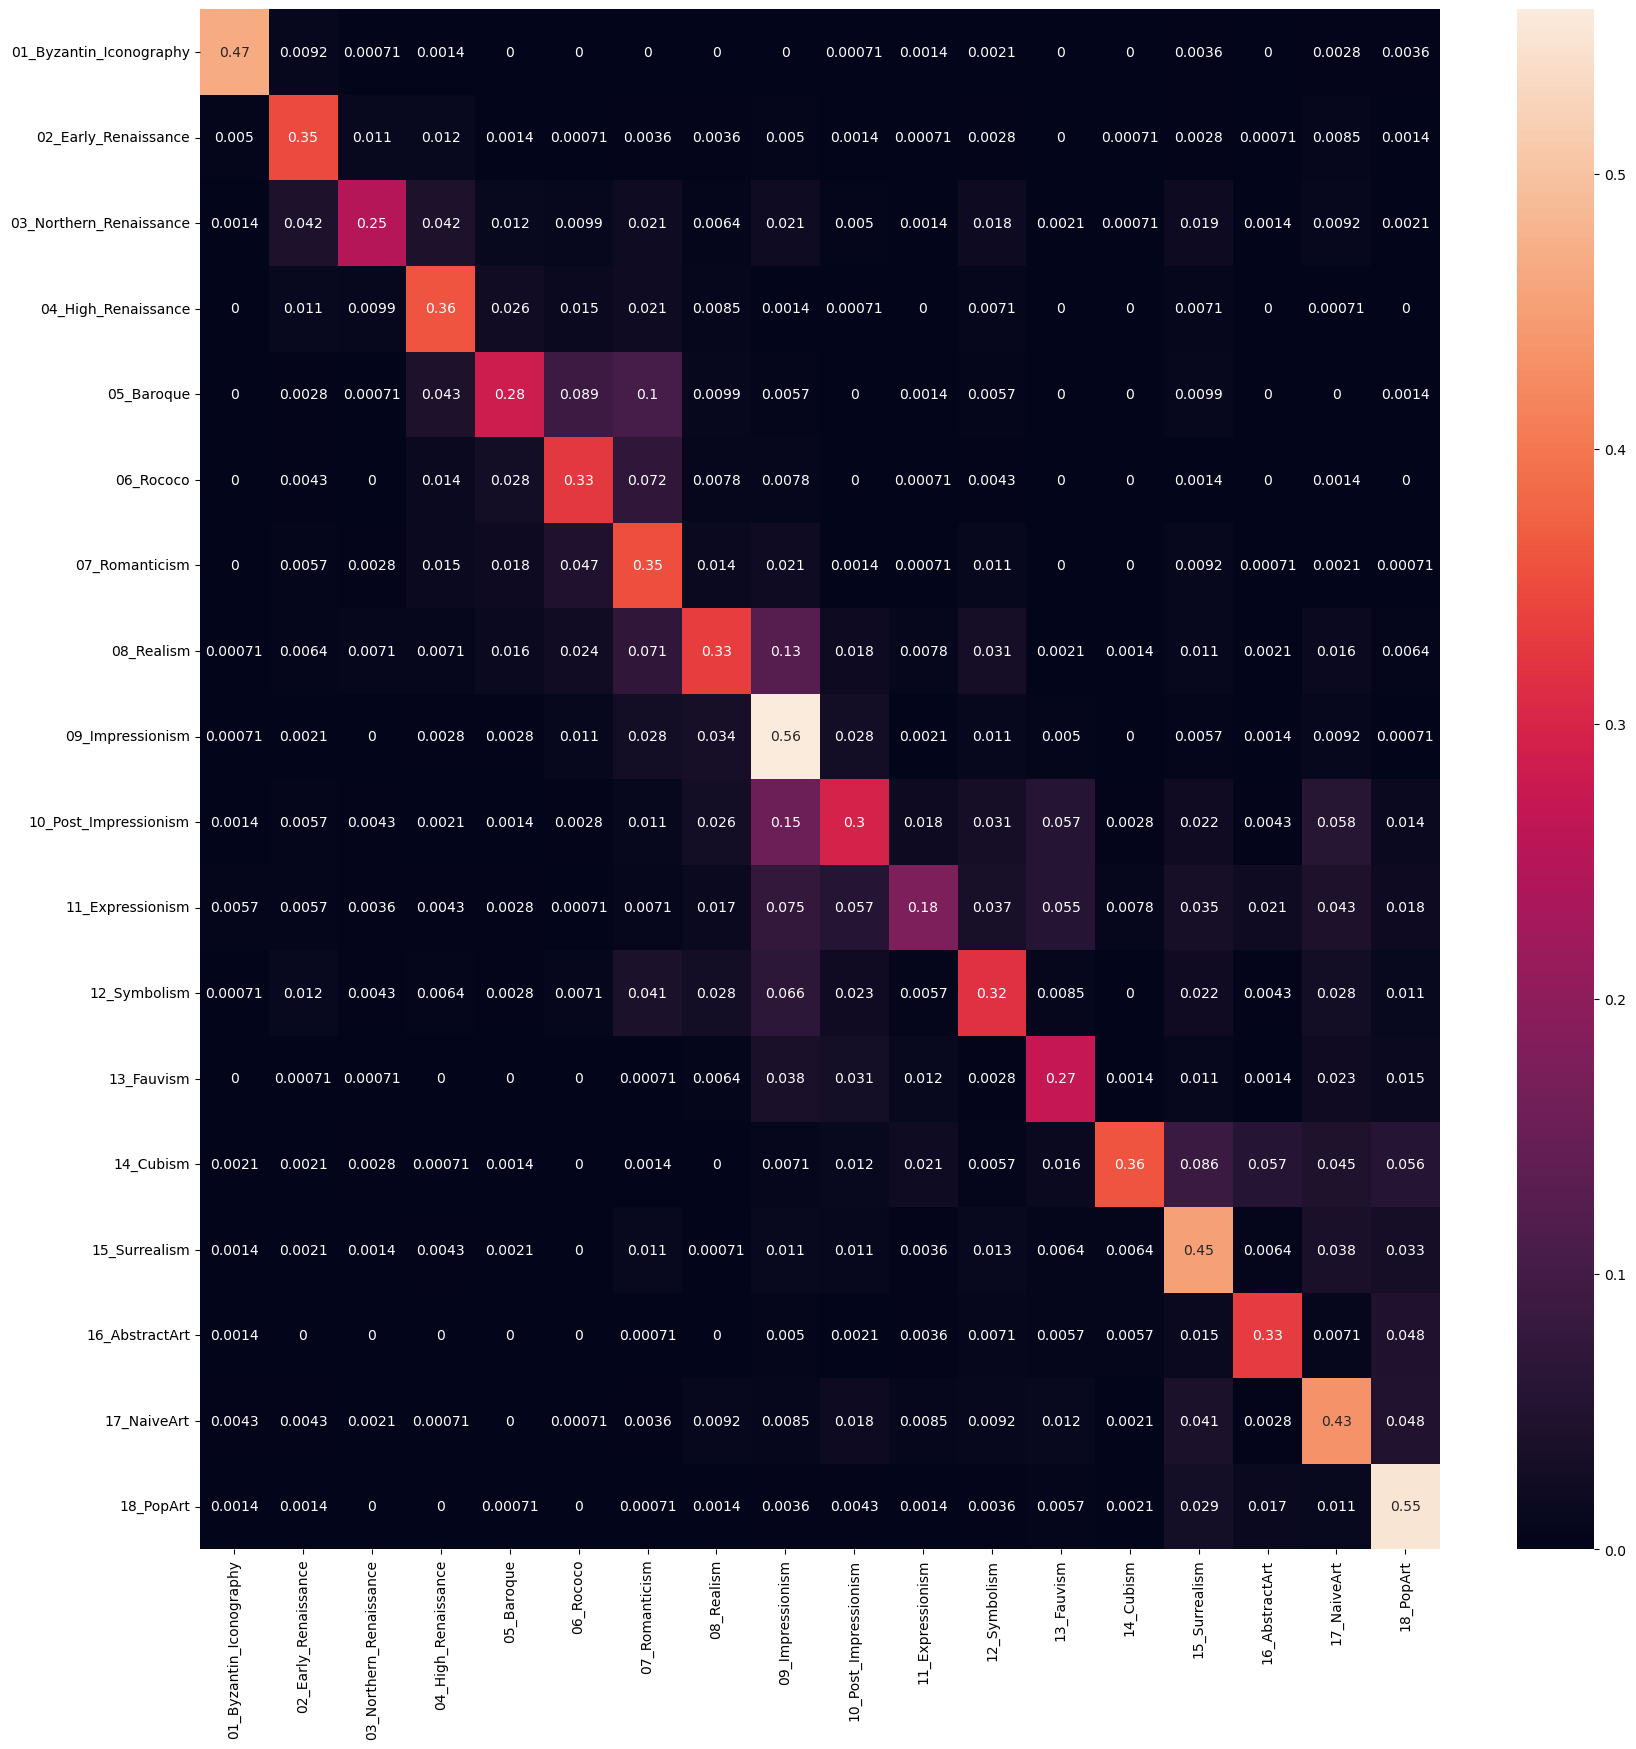

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = predictii
y_true = real_labels


# # iterate over test data
# for inputs, labels, triggers in test_loader:
#         output = mobile_net(inputs) # Feed Network

#         output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
#         y_pred.extend(output) # Save Prediction
        
#         labels = triggers.data.cpu().numpy()
#         y_true.extend(labels) # Save Truth


# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in class_mapping],
                     columns = [i for i in class_mapping])
plt.figure(figsize = (20,20))
sn.heatmap(df_cm, annot=True)
# plt.savefig('output.png')
plt.show()

In [ ]:
mobile_net = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobile_net.to(device)

for param in mobile_net.parameters():
    param.requires_grad = False

mobile_net.classifier[1] = nn.Linear(in_features=1280, out_features=18, bias=True)

# LOAD NET
mobile_net.load_state_dict(torch.load('mobileNet_PandoraTrain1.pt'))
mobile_net.cuda()
mobile_net.eval()

Real label: 03_Northern_Renaissance
Predicted label:  03_Northern_Renaissance


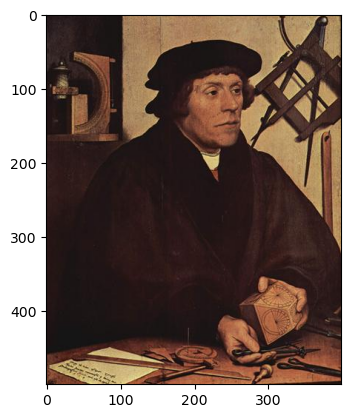

In [18]:
inv_map = {v: k for k, v in class_mapping.items()}


transf = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

picture = 4

# test_img = cv2.imread(train_data[picture])
# test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

img = cv2.imread(test_data[picture])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure()
plt.imshow(img)
print("Real label:", test_labels[picture])

data = transf(img)
data = data.to(torch.device('cuda'))
data = data[None, :]
# data.size()
# test_label = test_labels[picture].to(torch.device('cuda'))


predict = mobile_net.forward(data)
predict = predict.to(torch.device('cpu'))
predict = np.argmax(predict.detach().numpy(),axis=1)
print("Predicted label: ",inv_map[predict[0]])


In [60]:
# print(mobile_net)

# mobile_net.classifier[1] = nn.Linear(in_features=1280, out_features=18, bias=True)
